# Deep learning volatility

In [1]:
%config Completer.use_jedi=False
# import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import csv
import pandas as pd
import scipy


In [2]:
import os
os.chdir('Data')
# os.getcwd()
print(scipy.__version__)

1.7.0


In [3]:
import gzip
f= gzip.GzipFile("impliedVols_total.txt.gz","r")
df = np.load(f)
xx = df[:, :15]
yy = df[:, 15:]
len(df), len(df[0])

(200535, 87)

In [4]:
# maturities = np.array([0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0])# Time to expiry in years
# strikes = np.array([80, 85, 90, 95, 97, 99, 100, 101, 103, 105, 110, 115, 120, 122])
S0 = 1.
r = 0.
logmoneyness = np.array([-0.15, -0.12, -0.09, -0.06, -0.03, 0.0, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18])
strikes=np.exp(S0*logmoneyness)
maturities=np.array([0.05,0.15,0.3,0.4,0.5,0.6])
# maturities=np.array([0.03,0.05,0.07,0.09])
# strikes = np.array([85., 90., 95., 98., 100., 102., 105., 110., 115., 122.])

# strikes = np.array([5.25, 5.50, 5.75, 6.00, 6.25])
strikes_dim = len(strikes)
maturities_dim = len(maturities)
strikes_dim, maturities_dim

(12, 6)

In [5]:
#remove invalid paramters
invalid = np.where(yy == yy.min())[0]
xx = np.delete(xx, (invalid), axis=0)
yy = np.delete(yy, (invalid), axis=0)
print(xx.shape, yy.shape)
for i in range(15):
    print(np.min(xx[:, i]),np.max(xx[:, i]))

(200534, 15) (200534, 72)
0.5 2.5
1.0 1.5
0.1 0.6
0.01 0.5
0.0001 0.03
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5


# Step 1: Data Generation


### **Inputs: parameters in the rough quadratic Heston model** 
####   1.  $\alpha\in(0.5, 0.7);$
####   2. $\lambda\in(0.5, 1.5);$
####   3. $a\in(0.1, 0.75);$
####   4. $b\in(0.05,0.5);$
####   5. $c\in(0.0001, 0.01);$
####   6. $Z_0\in(0.05, 0.3).$  

    
### **Outputs:**
#### Implied volatility surface (11x7=77 points)

## Scaling:

### Model Parameters $\theta\to scale(\theta)\in[0,1]$
$$scale(\theta^i)=\frac{2\theta^i-(\theta^i_{min}+\theta^i_{max})}{\theta^i_{max}-\theta^i_{min}},\quad i \in |\Theta|$$


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, y_test = train_test_split(
    xx, yy, test_size=10000, random_state=42)
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scale = StandardScaler()
# y_train_transform = scale.fit_transform(y_train)
# y_test_transform = scale.transform(y_test)
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, test_size=20000, random_state=42)

$\alpha\in[0.505, 0.7],\; \lambda\in[0.5, 1.5],\; a\in[0.1, 0.75],\; b\in[0.05, 0.5],\; c\in[0.0001, 0.01],\; Z_0\in[0.05, 0.3]$

In [7]:
ub=np.max(xx, axis=0)
lb=np.min(xx, axis=0)
print(lb, ub)
def myscale(x):
    res=np.zeros(len(xx[0]))
    for i in range(len(xx[0])):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(len(xx[0]))
    for i in range(len(xx[0])):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res

[ 5.e-01  1.e+00  1.e-01  1.e-02  1.e-04 -5.e-01 -5.e-01 -5.e-01 -5.e-01
 -5.e-01 -5.e-01 -5.e-01 -5.e-01 -5.e-01 -5.e-01] [2.5  1.5  0.6  0.5  0.03 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5 ]


In [8]:
x_train_transform = np.array([myscale(x) for x in x_train])
x_test_transform = np.array([myscale(x) for x in X_test])
x_val_transform = np.array([myscale(x) for x in x_val])

x_train_transform.shape, x_test_transform.shape,x_val_transform.shape
# np.max(x_train_transform, axis=0)

((170534, 15), (10000, 15), (20000, 15))

# Step 2. Create the Neural Network

In [30]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')
def SiLU(x):
    return x*K.sigmoid(x)

input1 = keras.layers.Input(shape=(15,))
x1 = keras.layers.Dense(25,activation = SiLU)(input1)
x2=keras.layers.Dense(25,activation = SiLU)(x1) 
x3=keras.layers.Dense(25,activation = SiLU)(x2) 
x4=keras.layers.Dense(25,activation = SiLU)(x3) 
x5=keras.layers.Dense(25,activation = SiLU)(x4) 
x6=keras.layers.Dense(25,activation = SiLU)(x5) 
x7=keras.layers.Dense(strikes_dim*maturities_dim,activation = 'linear')(x6)

modelGEN = keras.models.Model(inputs=input1, outputs=x7)
modelGEN.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 25)                400       
_________________________________________________________________
dense_22 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_23 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_24 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_25 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_26 (Dense)             (None, 25)               

# Step 3. Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [31]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
optim = keras.optimizers.Adam(learning_rate = 0.001)
modelGEN.compile(loss = root_mean_squared_error, optimizer = optim)

In [32]:
from keras.callbacks import LearningRateScheduler, EarlyStopping
patience = 10 
NumEpochs=500
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="min",
                          verbose=1, 
                          patience=patience)
def decay_schedule(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr *= 0.5
    return lr 
        
lr_scheduler = LearningRateScheduler(decay_schedule)
modelGEN.fit(x_train_transform, y_train, 
             batch_size=128,
#              validation_split = 0.2,
             validation_data = (x_val_transform, y_val),
             epochs = 200, verbose = True,shuffle=1, callbacks=[earlystop, lr_scheduler])             
#              epochs = 100, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/200
1333/1333 [==============================] - 3s 2ms/step - loss: 0.1167 - val_loss: 0.0893
Epoch 2/200
1333/1333 [==============================] - 2s 2ms/step - loss: 0.0903 - val_loss: 0.0871
Epoch 3/200
1333/1333 [==============================] - 2s 2ms/step - loss: 0.0890 - val_loss: 0.0868
Epoch 4/200
1333/1333 [==============================] - 2s 2ms/step - loss: 0.0882 - val_loss: 0.0868
Epoch 5/200
1333/1333 [==============================] - 2s 2ms/step - loss: 0.0875 - val_loss: 0.0857
Epoch 6/200
1333/1333 [==============================] - 2s 2ms/step - loss: 0.0875 - val_loss: 0.0855
Epoch 7/200
1333/1333 [==============================] - 2s 2ms/step - loss: 0.0872 - val_loss: 0.0856
Epoch 8/200
1333/1333 [==============================] - 2s 2ms/step - loss: 0.0870 - val_loss: 0.0854
Epoch 9/200
1333/1333 [==============================] - 2s 2ms/step - loss: 0.0870 - val_loss: 0.0858
Epoch 10/200
1333/1333 [==============================] - 2s 2ms/step - l

### Store/Load optimal NN parameteres

In [33]:
modelGEN.save_weights('qrHestonNNWeights.h5')

In [34]:
modelGEN.load_weights('qrHestonNNWeights.h5')

In [35]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())
# np.savetxt("nnParameters.txt", np.asarray(NNParameters))
# NNParameters

# Step 4. Optimisation
### (Numpy Implementation of the Neural Network tends to be faster than Keras)

Here the *elu* function writes:
$$elu(x) = \begin{cases}e^{x}-1,\; x<0\\
x,\; x\geq 0.
\end{cases}$$

In [36]:
NumLayers=6
def SiLu(x):
    #Careful function ovewrites x
    sigmoid = 1./(1.+ np.exp(-x))
    return x*sigmoid

def SiLuPrime(y):
    tmp = 1./(1+np.exp(-y))
    return tmp + tmp**2*y*np.exp(-y)

def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=SiLu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(15)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=SiLuPrime(input1)
        
        input1=SiLu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
#     grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    grad=np.dot(grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

# Compute Implied vol relative errors on Test set

In [37]:
### Compute the 95% confidence interval for a given 2d array(column data as variable) and the filtered array
def filter_CI95(arr, li = 0.025, ui = 0.975):
    res = []
    lq = np.quantile(arr, li, axis=0)
    uq = np.quantile(arr, ui, axis=0)
    for i in range(len(arr[0])):
        sub = arr[:, i]
        tmp = sub[np.logical_and(sub>=lq[i], sub<=uq[i])]
        res.append(tmp)
#         print(len(tmp))
    return res 

<ipython-input-38-202db4f12908>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(maturities)


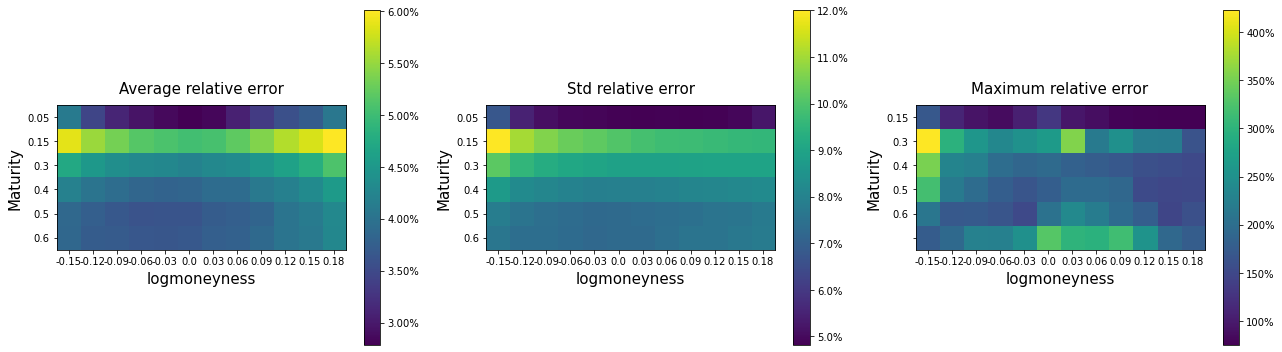

In [38]:
##### AVERAGE VALUES #######
X_sample = x_train_transform
y_sample = y_train

# prediction=[scale.inverse_transform(modelGEN.predict(X_sample[i].reshape(1,6))[0]) for i in range(len(X_sample))]
# prediction=[modelGEN.predict(X_sample[i].reshape(1,6))[0] for i in range(len(X_sample))]
prediction=[NeuralNetwork(X_sample[i]) for i in range(len(X_sample))]
# err_relative = np.abs((y_sample-prediction)/y_sample)
# err_CI95 = filter_CI95(err_relative)

RMSE = np.sqrt(np.mean(np.power(y_sample-prediction, 2), axis=1)) ### compute the RMSE of the calibrated smile surface

plt.figure(1,figsize=(18,5))
ax=plt.subplot(1,3,1)
# err = np.array([100*np.mean(e) for e in err_CI95]) 
err = np.mean(100*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(np.round(strikes,2))
ax.set_xticklabels(logmoneyness)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("logmoneyness",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
# err = np.array([100*np.std(e) for e in err_CI95]) 
err = 100*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(strikes)
ax.set_xticklabels(logmoneyness)

ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("logmoneyness",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
# err = np.array([100*np.max(e) for e in err_CI95]) 
err = 100*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(strikes)
ax.set_xticklabels(logmoneyness)
ax.set_yticklabels(maturities)
plt.xlabel("logmoneyness",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.savefig('qrHestonNNErrors.png', dpi=300)
plt.show()


# Plot sample Smiles

In [ ]:
import time
for j in range(10):
    sample_ind = j 
    X_sample = x_test_transform[sample_ind]
    y_sample = y_test[sample_ind]
    print(np.round(X_test[sample_ind],2))
    prediction=NeuralNetwork(X_sample)
#     prediction=scale.inverse_transform(modelGEN.predict(X_sample.reshape(1,6))[0])
    plt.figure(1,figsize=(10,6))
    for i in range(maturities_dim):
        plt.subplot(2,3,i+1)

        plt.plot(logmoneyness, y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
        plt.plot(logmoneyness, prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
#     time.sleep(5)
    

In [ ]:
%matplotlib qt 
# %matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection = '3d')
X, Y = np.meshgrid(logmoneyness, maturities)
rng = np.random.default_rng()
i = rng.integers(len(x_test_transform))
print("Test sample id: ",i)
Z = NeuralNetwork(x_test_transform[i]).reshape(maturities_dim, -1)
surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("logmoneyness")
ax.set_ylabel("maturities")
ax.set_zlim(-.25, .8)
ax.zaxis.set_major_formatter("{x:.02f}")
fig.colorbar(surf, shrink=0.25, aspect=5)
plt.show()

$\alpha\in[0.505, 0.7],\; \lambda\in[0.5, 1.5],\; a\in[0.1, 0.75],\; b\in[0.05, 0.5],\; c\in[0.0001, 0.01],\; Z_0\in[0.05, 0.3]$

# Use gradient methods for optimisation

In [ ]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-y_test[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-y_test[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-y_test[sample_ind])

def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [ ]:
import time

Approx=[]
Timing = []
solutions=np.zeros((2, 15))
init=np.zeros(15)
for i in range(len(X_test)):
    disp=str(i+1)+"/" + str(len(X_test))
    print (disp, end="\r")
    times = np.zeros(2)
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian, tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    
    start= time.time()
#     I=scipy.optimize.least_squares(CostFuncLS, I.x, JacobianLS,method='lm',args=(i,),gtol=1E-10)
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing), 15))
# print("solution: ", np.round(np.mean(Approx, axis=0), 6))

In [ ]:
for i in range(227,233):
    print(Approx[i][0])

# Save the Lavenberg-Marquardt Optimal parameters

In [ ]:
LMParameters=np.array([Approx[i][0] for i in range(len(Approx))])
np.savetxt("NNParametersQuadraticRoughHeston.txt",LMParameters)
LMParameters = np.loadtxt("NNParametersQuadraticRoughHeston.txt")
LMParameters.shape
init_lm = np.mean(LMParameters, axis=0)
# Approx[0][0], Approx[0][1]
init_lm

In [ ]:
np.max(LMParameters, axis=0)

# Calibration Errors with Levenberg-Marquardt

In [ ]:
%matplotlib inline
titles=["$\\lambda$","$\\eta$","$a$","$b$", "$c$"]
for i in range(1, 11):
    s = "$Z0_{"+str(i)+"}$"
    titles.append(s)
average_nae=np.zeros([15, len(X_test)])
fig=plt.figure(figsize=(13,14))
for u in range(15):
    ax=plt.subplot(5,3,u+1)
    x=X_test[:,u]
    lu = ub[u]-lb[u]
    average_nae[u,:]=np.abs(LMParameters[:,u]-x)/lu
    y = np.abs(LMParameters[:,u]-x)/lu
    
    plt.plot(x, y,'b*')
    plt.title(titles[u],fontsize=20)
    plt.ylabel('NAE Error',fontsize=15)
#     plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )

    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
#     plt.text(0.5, 0.8, 'Average: %1.2f%\n Median:   %1.2f% '%(np.mean(y),np.quantile(y,0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('qrHestonParameterNAEErrors.png', dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.clf()
plt.subplot(121)
ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(15):
    p=plt.plot(100*q,np.quantile(average_nae[u,:],q),label=titles[u])
    c=p[0].get_color()
    ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(100*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter normalized absolute error(NAE)",fontsize=20)
plt.legend(fontsize=10, loc=2)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("NAE error",fontsize=17)
# plt.gca().yaxis.set_major_formatter(mtick.FixedFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()

plt.subplot(122)
ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(100*q,np.quantile(100*RMSE,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(100*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('qrHestonErrorCDF.png', dpi=300)
plt.show()


## Calibration on market data

In [ ]:
from scipy import  interpolate
from scipy.interpolate import griddata
import json

df_logmoneyness_market = json.load(open('logmoneyness_market.json'))
df_market = json.load(open('impliedVols_market.json'))
### maturities and strikes on the market
maturities_market = [0.06, 0.15, 0.31, 0.56]
print("Market logmoneyness: ",df_logmoneyness_market[10])
print("Model logmoneyness: ",np.round(logmoneyness,3))
print("Model Maturities: " ,maturities)
# df_market

In [ ]:
def interpolation_NN(x, maturities_market, logmoneyness_market):
    """
    a function for the interpolation of the market data to the NeuralNetwork
    Input: 
        x: the input sample for the Neural Network function
        logmonyness_market(dim=9), maturities_market(dim=4)
    Output: 
        f: the interpolation results of the NeuralNetwork, 
        df: the interpolation results of the NeuralNetworkGradient
    """
    
    sbs = interpolate.RectBivariateSpline(maturities, logmoneyness, NeuralNetwork(x).reshape(maturities_dim,-1))
    fnew = sbs(maturities_market, logmoneyness_market) 
#     X,Y = np.meshgrid(logmoneyness, maturities)
#     sbs = interpolate.SmoothBivariateSpline(X.ravel(), Y.ravel(), NeuralNetwork(x))
#     return sbs(logmoneyness_market, maturities_market).ravel()
     
    return fnew.ravel()

def interpolation_NN_Gradient(x, maturities_market, logmoneyness_market):
    """
    a function for the interpolation of the market data to the NeuralNetworkGradient
    Input: 
        x: the input sample for the Neural Network function
        logmonyness_market(dim=9), maturities_market(dim=4)
    Output: 
        gradient: the interpolation results of the NeuralNetworkGradient
    """
    gradient    = np.zeros((6, len(logmoneyness_market)*len(maturities_market)))
    nnGradient  = NeuralNetworkGradient(x)
    
    for i in range(6):
        sbs = interpolate.RectBivariateSpline(maturities, logmoneyness, nnGradient[i].reshape(maturities_dim,-1))
        gradient[i] = sbs(maturities_market, logmoneyness_market).ravel()

    return gradient
    


In [ ]:
def CostFunc_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    interpolated = interpolation_NN(x,maturities_market, logmoneyness_market)
    return np.sum(np.power(interpolated - df_market[sample_ind], 2))

def Jacobian_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    interpolated = interpolation_NN(x,maturities_market, logmoneyness_market)
    gradient = interpolation_NN_Gradient(x,maturities_market, logmoneyness_market)
    
    return 2*np.sum((interpolated - df_market[sample_ind])*gradient,axis=1)

# #Cost Function for Levenberg Marquardt

def CostFuncLS_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    interpolated = interpolation_NN(x,maturities_market, logmoneyness_market)
    return (interpolated - df_market[sample_ind])

def JacobianLS_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    return interpolation_NN_Gradient(x,maturities_market, logmoneyness_market).T

In [ ]:
def CostFunc_c(c, sample_ind, init_x):
    x1 = init_x.copy()
    x1[-2] = c 
    interpolated = interpolation_NN(x1, maturities_market, df_logmoneyness_market[sample_ind])
    return np.sum(np.power(interpolated - df_market[sample_ind], 2))

In [ ]:
from scipy.optimize import  Bounds, LinearConstraint
bounds = Bounds([-1.]*15, [1.]*15)
l = np.array([1., np.inf, np.inf, np.inf, np.inf, np.inf])
constraints = LinearConstraint(np.diag(np.ones(15)), -np.ones(15), np.ones(15))

# constraints = LinearConstraint(np.diag(np.ones(6)), -np.ones(6), np.ones(6))

bounds = [(-1., 1.)]*15


In [ ]:
import time 
Approx=[]
Timing = []

solutions=np.zeros([4,15])
# init = myscale(np.array([0.51, 1.2, 0.384, 0.095, 0.0025, 0.1]))
init = np.zeros(15)
times = np.zeros(4)
for i in range(len(df_market)):
    disp=str(i+1)+"/" + str(len(df_market))
    print (disp, end="\r")
#     args=(i,)
#     start= time.time()
#     I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='Powell', tol=1E-10,
#                               bounds = bounds,
#                               options={"maxiter": 5000})
#     end= time.time()
#     solutions[1, :]=myinverse(I.x)
#     times[1] = end-start
    
    
    # Cobyla - gradient free method "
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='COBYLA', tol=1E-10,
                              constraints = constraints,
                              options={"maxiter": 5000})
    end= time.time()
    solutions[2, :]=myinverse(I.x)
    times[2] = end-start
    
    ## Nelder-Mead Method
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='Nelder-Mead', tol=1E-10,
                              bounds = bounds,
                              options={"maxiter": 5000, "adaptive":True})
    end= time.time()
    solutions[3, :]=myinverse(I.x)
    times[3] = end-start
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing, axis=0), 6))
#     start= time.time()
# #     I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP', jac=Jacobian,bounds=bnds, tol=1E-10,options={"maxiter":5000})
#     I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP', jac=Jacobian, tol=1E-10,options={"maxiter":5000})
#     end= time.time()
#     solutions[0,:]=myinverse(I.x)
#     times[0]=end-start
    
#     start= time.time()
#     I=scipy.optimize.minimize(CostFunc_,x0=init,args=(i,),method='L-BFGS-B', jac=Jacobian_,  tol=1E-10, options={"maxiter":5000})
# #     I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B', jac=Jacobian,bounds=bnds, tol=1E-10,options={"maxiter":5000})
#     end= time.time()
#     solutions[1,:]=myinverse(I.x)
# # #     print(solutions[1,:]) 
#     times[1]=end-start
    
#    # Levenberg-Marquardt
#     start= time.time()
#     I=scipy.optimize.least_squares(CostFuncLS, x0=init,jac=JacobianLS,method='lm', args=(i,),gtol=1E-10)
# #     I=scipy.optimize.least_squares(CostFuncLS, x0=init,jac=JacobianLS,bounds=(-np.ones(6), np.ones(6)), args=(i,),gtol=1E-10)
#     end= time.time()
#     solutions[2, :]=myinverse(I.x)
#     times[2] = end-start
    
    
# print("solution: ", np.round(np.mean(Approx, axis=0), 6))

In [ ]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
for i in range(2):
    print(Approx[i][2], Approx[i][3])


In [ ]:
### results with bounds
for j in range(1,4):
    tmp = [Approx[i][j] for i in range(len(Approx))]
    print("Mean:",np.mean(tmp, axis=0))
    print("Std: ",np.round(np.std(tmp, axis=0), 10))
    print("-------------------------------------------------------------------------------")
    

In [ ]:
### Interpolation figure
# %matplotlib qt 

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection = '3d')
init = np.zeros(6)

X, Y = np.meshgrid(logmoneyness, maturities)
Z = NeuralNetwork(init).reshape(maturities_dim, -1)

logmoneyness_market = df_logmoneyness_market[0]
X1, Y1 = np.meshgrid(logmoneyness_market, maturities_market)
Z1 = interpolation_NN(init, maturities_market, logmoneyness_market).reshape(len(maturities_market), -1)


surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5)
points = ax.scatter(X1, Y1, Z1, c='g')

ax.set_xlabel("logmoneyness")
ax.set_ylabel("maturities")
ax.set_zlim(-.25, .4)
ax.zaxis.set_major_formatter("{x:.02f}")
fig.colorbar(surf, shrink=0.25, aspect=5)

plt.show()

In [ ]:
%matplotlib inline

for sample_ind  in range(2):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    l = len(logmoneyness_market)
    
    X_sample = myscale(Approx[sample_ind][3])
    y_sample = df_market[sample_ind]
    prediction=interpolation_NN(X_sample, maturities_market, logmoneyness_market)
    print("loss: ",CostFunc_(X_sample, sample_ind))
    print(Approx[sample_ind][3])
    
    plt.figure(1,figsize=(12,3))
    for i in range(len(maturities_market)):
        plt.subplot(1,4,i+1)
 
        plt.plot(logmoneyness_market, y_sample[i*l :(i+1)*l],'b',label="Input data")
        plt.plot(logmoneyness_market, prediction[i*l :(i+1)*l],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities_market[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
strikes_dim=11
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def plot_func(sample_ind, alpha,Lambda,a,b,c, Z0):
    x0=myscale(np.array([alpha,Lambda,a,b,c, Z0]))
    Smiles=df_market[sample_ind]
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    strikes_dim_market = len(df_logmoneyness_market[sample_ind])
    
    Smiles_interpolated = interpolation_NN(x0, maturities_market, df_logmoneyness_market[sample_ind])
    
    plt.figure(1,figsize=(13,3))
    
    for i in range(4):
        plt.subplot(1,4,i+1)

        y1 = Smiles[i*strikes_dim_market:(i+1)*strikes_dim_market]
        y2 = Smiles_interpolated[i*strikes_dim_market:(i+1)*strikes_dim_market]
        plt.plot(logmoneyness_market,y1, '*r',label="Real Market Smile")
        plt.plot(logmoneyness_market,y2, '*g',label=" NN Approx interpolation")
        
        y = np.concatenate((y1, y2))
        plt.ylim(np.min(y)-.05, np.max(y)+.1)
        plt.title("Maturity=%1.2f "%maturities_market[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show() 


interact(plot_func, sample_ind = widgets.IntSlider(value=0, 
                                               min=0,
                                               max=len(df_market),
                                               step=1),
         alpha = widgets.FloatSlider(value=0.6,
                                               min=0.505,
                                               max=0.8,
                                               step=0.02),
         Lambda = widgets.FloatSlider(value=1.2,
                                               min=0.8,
                                               max=1.5,
                                               step=0.02),
         a = widgets.FloatSlider(value=0.25,
                                               min=0.1,
                                               max=0.5,
                                               step=0.02),
         b = widgets.FloatSlider(value=0.1,
                                               min=0.01,
                                               max=0.5,
                                               step=0.02),
         c = widgets.FloatSlider(value=0.005,
                                               min=0.001,
                                               max=0.01,
                                               step=0.005),
         Z0 = widgets.FloatSlider(value=0.1,
                                               min=0.05,
                                               max=0.3,
                                               step=0.05))

In [ ]:
logmoneyne = np.array([-0.15, -0.12, -0.09, -0.06, -0.03, 0.0, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18])
np.round(np.exp(logmoneyne),2)